In [2]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import seaborn as sns
import matplotlib.pyplot as plt
import math
import itertools 
import statsmodels.api as sm
#import statsmodels.api as sm

# Лабораторна робота №2

## Одновимірна лінійна регресія

In [3]:
df = pd.read_csv('lin-0.7.txt', sep='\s+', header=None, names=['colX', 'colY'])
df = df.sort_values(by = 'colX').reset_index(drop=True)
df

,colX,colY
0,0.4855,42.6820
1,2.6856,40.4497
2,2.9935,35.2261
3,3.1647,40.9561
4,3.2765,41.9825
...,...,...
295,15.8989,21.0268
296,15.9617,22.0177
297,16.1706,23.1569
298,16.2964,18.5337


In [4]:
def new_pearson(dataX, dataY) :
    alpha = 0.05
    size = dataX.size
    meanX = dataX.mean()
    meanY = dataY.mean()
    dataXY = dataX * dataY
    meanXY = dataXY.mean()
    stdX = dataX.std(ddof = 0)
    stdY = dataY.std(ddof = 0)
    R = (meanXY - meanX * meanY) / (stdX * stdY)
    statistic = (R * math.sqrt(size - 2)) / math.sqrt(1 - R*R)
    quantile = ss.t.ppf(1-alpha/2, size-2)
    quantile_norm = ss.norm.ppf(1-alpha/2)
    statistic_start = R + ((R*(1-R*R)) / math.sqrt(2*size)) - (quantile_norm * ((1 - R*R) / math.sqrt(size - 1)))
    statistic_end = R + ((R*(1-R*R)) / math.sqrt(2*size)) + (quantile_norm * ((1 - R*R) / math.sqrt(size - 1)))
    return R
        

In [4]:
def get_parameters_one(dataX, dataY) :
    size = dataX.size
    R = new_pearson(dataX, dataY)
    stdX = dataX.std(ddof = 0)
    stdY = dataY.std(ddof = 0)
    meanX = dataX.mean()
    meanY = dataY.mean()
    alpha = 0.05
    quantile = ss.t.ppf(1 - alpha / 2, size - 2)
    
    a1 = R * (stdY / stdX)
    a0 = meanY - a1 * meanX
    
    forStdEps = pd.Series(pow((dataY[i] - a0 - a1 * dataX[i]), 2) for i in range(size))
    stdEpsSquared = sum(forStdEps) / (size - 2)
    
    stdA0 = math.sqrt((stdEpsSquared / size) * (1 + pow(meanX , 2) / pow(stdX , 2)))
    stdA1 = math.sqrt(stdEpsSquared / (size * pow(stdX , 2)))
    
    a0Start = a0 - quantile * stdA0
    a0End = a0 + quantile * stdA0
    a1Start = a1 - quantile * stdA1
    a1End = a1 + quantile * stdA1
    
    statisticA0 = a0 / stdA0
    statisticA1 = a1 / stdA1
    
    pValA0 = 2 * (1 - ss.t.cdf(x = abs(statisticA0), df = (size - 2)))
    pValA1 = 2 * (1 - ss.t.cdf(x = abs(statisticA1), df = (size - 2)))
    
    table = pd.DataFrame(columns={"Показник" : 1, "a0": 2,  "a1": 3})
    table.loc[len(table)] = ["Значення", a0, a1]
    table.loc[len(table)] = ["std", stdA0, stdA1]
    table.loc[len(table)] = ["interval", '[%6.3f ; %6.3f]' % (a0Start, a0End), '[%6.3f ; %6.3f]' % (a1Start, a1End)]
    table.loc[len(table)] = ["statistic", statisticA0, statisticA1]
    table.loc[len(table)] = ["p-value", pValA0, pValA1]
    if abs(statisticA0) <= quantile :
        if abs(statisticA1) <= quantile :
            table.loc[len(table)] = ["Значущість", "Дорівнює нулю", "Дорівнює нулю"]
            table.loc[len(table)] = ["Висновок", "Лінія регресії проходить через початок координат", "Регресія не значуща"]
        else :
            table.loc[len(table)] = ["Значущість", "Дорівнює нулю", "Відмінний від нуля"]
            table.loc[len(table)] = ["Висновок", "Лінія регресії проходить через початок координат", "Регресія значуща"]
    else :
        if abs(statisticA1) <= quantile :
            table.loc[len(table)] = ["Значущість", "Відмінний від нуля", "Дорівнює нулю"]
            table.loc[len(table)] = ["Висновок", "Лінія регресії не проходить через початок координат", "Регресія не значуща"]
        else :
            table.loc[len(table)] = ["Значущість", "Відмінний від нуля", "Відмінний від нуля"]
            table.loc[len(table)] = ["Висновок", "Лінія регресії не проходить через початок координат", "Регресія значуща"]
    display(table.style.hide_index())
    return a0, a1, stdEpsSquared, stdA1

In [38]:
def get_regression_and_intervals(dataX, a0, a1, stdEpsSquared, stdA1) :
    size = dataX.size
    alpha = 0.05
    quantile = ss.t.ppf(1 - alpha / 2, size - 2)
    meanX = dataX.mean()
    reg = pd.Series(a0 + a1 * dataX[i] for i in range(size))
    stdDf = pd.Series((stdEpsSquared / size) + stdA1 * pow((dataX[i] - meanX) , 2) for i in range(size))
    regStart = pd.Series(reg[i] - quantile * math.sqrt(stdDf[i]) for i in range(size))
    regEnd = pd.Series(reg[i] + quantile * math.sqrt(stdDf[i]) for i in range(size))
    progStart = pd.Series(reg[i] - quantile * math.sqrt(stdDf[i] + stdEpsSquared) for i in range(size))
    progEnd = pd.Series(reg[i] + quantile * math.sqrt(stdDf[i] + stdEpsSquared) for i in range(size))
    return reg, regStart, regEnd, progStart, progEnd

In [91]:
# на відсортованих даних
def show_plot2(dataX, dataY, reg, regStart, regEnd, progStart, progEnd) :
    plt.scatter(dataX, dataY, color = 'black', s = 10)
    plt.plot(dataX, reg, 'g')
    plt.plot(dataX, regStart, 'r')
    plt.plot(dataX, regEnd, 'r')
    plt.plot(dataX, progStart, 'b')
    plt.plot(dataX, progEnd, 'b')
    plt.show() 

In [7]:
def get_determination_coefficient(dataX, dataY, stdEpsSquared) :
    size = dataY.size
    stdY = dataY.std(ddof = 0)
    RSquared = (1 - ((stdEpsSquared * (size - 2)) / (size * pow(stdY,2))))
    R = new_pearson(dataX, dataY)
    RSquaredPearson = (R * R) 
    return RSquared, RSquaredPearson

In [8]:
def get_f_test(dataX, dataY, stdEpsSquared, reg) :
    meanY = dataY.mean()
    size = dataY.size
    forF = pd.Series(pow((reg[i] - meanY), 2) for i in range(size))
    F = sum(forF) / stdEpsSquared
    RSquared = get_determination_coefficient(dataX, dataY, stdEpsSquared)[0]
    p = 1
    statistic = (RSquared / (1 - RSquared)) * ((size - p - 1) / p)
    pValue = 1 - ss.f.cdf(statistic, p, size-p-1)
    quantile = ss.f.ppf(1-0.05, p, size-p-1)
    return F, statistic, pValue, quantile

In [9]:
def my_coef(data) :
    alpha = 0.05
    size = data.size

    A = ss.skew(data)
    sigmaA = math.sqrt((6 * (size - 2)) / ((size + 1) * (size + 3)))
    uA = (A - 0) / sigmaA
    
    E = ss.kurtosis(data)
    sigmaE = math.sqrt((24 * size * (size - 2) * (size - 3))/(pow((size + 1), 2) * (size + 3 * (size + 5))))
    uE = (E - 0) / sigmaE
    
    quantile = ss.norm.ppf(1-alpha/2)
    absUA = abs(uA)
    absUE = abs(uE)
    
    table = pd.DataFrame(columns={"Параметр","Значення"})
    table.loc[len(table)] = ["A", A]
    table.loc[len(table)] = ["E", E]
    table.loc[len(table)] = ["ABS uA", absUA]
    table.loc[len(table)] = ["ABS uE", absUE]
    table.loc[len(table)] = ["Quantile", quantile]
    table.loc[len(table)] = ["skewtest statistic", ss.skewtest(data).statistic]
    table.loc[len(table)] = ["skewtest pvalue", ss.skewtest(data).pvalue]
    table.loc[len(table)] = ["kurtosistest statistic", ss.kurtosistest(data).statistic]
    table.loc[len(table)] = ["kurtosistest pvalue", ss.kurtosistest(data).statistic]
    table.loc[len(table)] = ["normaltest statistic", ss.normaltest(data).statistic]
    table.loc[len(table)] = ["normaltest pvalue", ss.normaltest(data).statistic]
    table.loc[len(table)] = ["normaltest pvalue > alpha", "ідентифікується" if ss.normaltest(data)[1] > alpha else "не ідентифікується"]
    table.loc[len(table)] = ["shapiro statistic", ss.shapiro(data).statistic]
    table.loc[len(table)] = ["shapiro pvalue", ss.shapiro(data).statistic]
    table.loc[len(table)] = ["shapiro pvalue > alpha", "ідентифікується" if ss.shapiro(data)[1] > alpha else "не ідентифікується"]
    if absUA <= quantile and absUE <= quantile :
        table.loc[len(table)] = ["Висновок", "Нормальний розподіл ідентифікується"]
    else :
        table.loc[len(table)] = ["Висновок", "Нормальний розподіл не ідентифікується"]
    display(table.style.hide_index())

In [10]:
def get_residual_plot(dataY, reg) :
    size = dataY.size
    residuals = pd.Series(dataY[i] - reg[i] for i in range(size))
    plt.scatter(reg, residuals, color = 'black', s = 10)
    plt.show()
    my_coef(residuals)
    ss.probplot(residuals, plot=plt)
    plt.show()

In [11]:
def get_quality_scores(dataX, dataY, stdEpsSquared, reg) :
    RSquared, RSquaredPearson = get_determination_coefficient(dataX, dataY, stdEpsSquared)
    FTest, statistic, pValue, quantileF = get_f_test(dataX, dataY, stdEpsSquared, reg)
    table = pd.DataFrame(columns={"Показник" : 1, "Значення": 2})
    table.loc[len(table)] = ["Залишкова дисперсія", stdEpsSquared]
    table.loc[len(table)] = ["Коефіцієнт детермінації", RSquared]
    table.loc[len(table)] = ["Коефіцієнт детермінації (Пірсон)", RSquaredPearson]
    table.loc[len(table)] = ["F-test", FTest]
    table.loc[len(table)] = ["F-test statistic", statistic]
    table.loc[len(table)] = ["F-test p-value", pValue]
    table.loc[len(table)] = ["quantileF", quantileF]
    if abs(statistic) <= quantileF :
        table.loc[len(table)] = ["Висновок", "Регресія не значуща"]
    else :
        table.loc[len(table)] = ["Висновок", "Регресія значуща"]
    display(table.style.hide_index())
    get_residual_plot(dataY, reg)

In [130]:
def get_regression_and_intervals(dataX, a0, a1, stdEpsSquared, stdA1) :
    size = dataX.size
    alpha = 0.05
    quantile = ss.t.ppf(1 - alpha / 2, size - 2)
    meanX = dataX.mean()
    reg = pd.Series(a0 + a1 * dataX[i] for i in range(size))
    stdDf = pd.Series(math.sqrt((stdEpsSquared / size) + pow(stdA1 * (dataX[i] - meanX) , 2)) for i in range(size))
    regStart = pd.Series(reg[i] - quantile * stdDf[i] for i in range(size))
    regEnd = pd.Series(reg[i] + quantile * stdDf[i] for i in range(size))
    progStart = pd.Series(reg[i] - quantile * math.sqrt(pow(stdDf[i],2) + stdEpsSquared) for i in range(size))
    progEnd = pd.Series(reg[i] + quantile * math.sqrt(pow(stdDf[i],2) + stdEpsSquared) for i in range(size))
    return reg, regStart, regEnd, progStart, progEnd

In [105]:
# на відсортованих даних
def show_plot(dataX, dataY) :
    sortedDf = pd.DataFrame({'x': dataX, 'y':dataY})
    sortedDf.sort_values(by = 'x', inplace = True)
    
    a0, a1, stdEpsSquared, stdA1 = get_parameters_one(sortedDf['x'], sortedDf['y']) 
    reg, regStart, regEnd, progStart, progEnd = get_regression_and_intervals(sortedDf['x'], a0, a1, stdEpsSquared, stdA1)
    plt.scatter(sortedDf['x'], sortedDf['y'], color = 'black', s = 10)
    reg = pd.Series(a0 + a1 * sortedDf['x'][i] for i in range(sortedDf['y'].size))
    plt.plot(sortedDf['x'], reg, 'g')
    plt.plot(sortedDf['x'], regStart, 'r')
    plt.plot(sortedDf['x'], regEnd, 'r')
    plt.plot(sortedDf['x'], progStart, 'b')
    plt.plot(sortedDf['x'], progEnd, 'b')
    plt.show() 

Показник,a0,a1
Значення,42.253519,-1.247950
std,0.772134,0.076316
interval,[40.734 ; 43.773],[-1.398 ; -1.098]
statistic,54.723023,-16.352408
p-value,0.000000,0.000000
Значущість,Відмінний від нуля,Відмінний від нуля
Висновок,Лінія регресії не проходить через початок координат,Регресія значуща


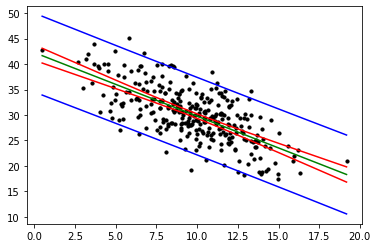

Показник,Значення
Залишкова дисперсія,14.905597
Коефіцієнт детермінації,0.472941
Коефіцієнт детермінації (Пірсон),0.472941
F-test,267.401248
F-test statistic,267.401248
F-test p-value,0.000000
quantileF,3.872853
Висновок,Регресія значуща


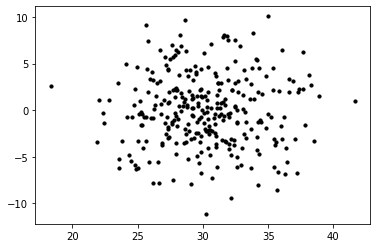

Параметр,Значення
A,0.050089
E,-0.196332
ABS uA,0.357734
ABS uE,0.081601
Quantile,1.959964
skewtest statistic,0.362337
skewtest pvalue,0.717101
kurtosistest statistic,-0.588214
kurtosistest pvalue,-0.588214
normaltest statistic,0.477283


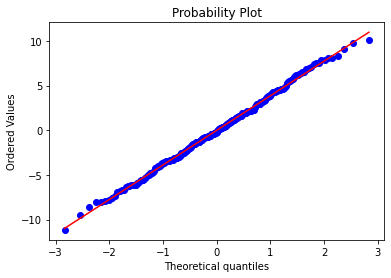

In [140]:
a0, a1, stdEpsSquared, stdA1 = get_parameters_one(df['colX'], df['colY']) 
reg, regStart, regEnd, progStart, progEnd = get_regression_and_intervals(df['colX'], a0, a1, stdEpsSquared, stdA1)
#show_plot(df['colX'], df['colY'])
show_plot2(df['colX'], df['colY'], reg, regStart, regEnd, progStart, progEnd)
get_quality_scores(df['colX'], df['colY'], stdEpsSquared, reg)

In [142]:
X = pd.DataFrame(df['colX'])
X_ = sm.add_constant(X)          # добавляем фиктивную переменную для регрессии со свободным челеном
ols = sm.OLS(df['colY'], X_)              # cоздаем модель
model2 = ols.fit()               # обучаем модель на данных
print(model2.summary())   

                            OLS Regression Results                            
Dep. Variable:                   colY   R-squared:                       0.473
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                     267.4
Date:                Wed, 25 May 2022   Prob (F-statistic):           2.41e-43
Time:                        15:49:38   Log-Likelihood:                -829.94
No. Observations:                 300   AIC:                             1664.
Df Residuals:                     298   BIC:                             1671.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         42.2535      0.772     54.723      0.0

## Багатовимірна лінійна регресія

In [5]:
df = pd.read_csv('Boston.csv', sep=',')
df = df.sort_values(by = 'medv').reset_index(drop=True)
data = df
df

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,38.35180,0.0,18.10,0,0.693,5.453,100.0,1.4896,24,666,20.2,396.90,30.59,5.0
1,67.92080,0.0,18.10,0,0.693,5.683,100.0,1.4254,24,666,20.2,384.97,22.98,5.0
2,25.04610,0.0,18.10,0,0.693,5.987,100.0,1.5888,24,666,20.2,396.90,26.77,5.6
3,9.91655,0.0,18.10,0,0.693,5.852,77.8,1.5004,24,666,20.2,338.16,29.97,6.3
4,45.74610,0.0,18.10,0,0.693,4.519,100.0,1.6582,24,666,20.2,88.27,36.98,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,2.01019,0.0,19.58,0,0.605,7.929,96.2,2.0459,5,403,14.7,369.30,3.70,50.0
502,0.01381,80.0,0.46,0,0.422,7.875,32.0,5.6484,4,255,14.4,394.23,2.97,50.0
503,0.01501,90.0,1.21,1,0.401,7.923,24.8,5.8850,1,198,13.6,395.52,3.16,50.0
504,0.52693,0.0,6.20,0,0.504,8.725,83.0,2.8944,8,307,17.4,382.00,4.63,50.0


In [6]:
data.insert(0, "x0", 1, True)
data

,x0,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,1,38.35180,0.0,18.10,0,0.693,5.453,100.0,1.4896,24,666,20.2,396.90,30.59,5.0
1,1,67.92080,0.0,18.10,0,0.693,5.683,100.0,1.4254,24,666,20.2,384.97,22.98,5.0
2,1,25.04610,0.0,18.10,0,0.693,5.987,100.0,1.5888,24,666,20.2,396.90,26.77,5.6
3,1,9.91655,0.0,18.10,0,0.693,5.852,77.8,1.5004,24,666,20.2,338.16,29.97,6.3
4,1,45.74610,0.0,18.10,0,0.693,4.519,100.0,1.6582,24,666,20.2,88.27,36.98,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,1,2.01019,0.0,19.58,0,0.605,7.929,96.2,2.0459,5,403,14.7,369.30,3.70,50.0
502,1,0.01381,80.0,0.46,0,0.422,7.875,32.0,5.6484,4,255,14.4,394.23,2.97,50.0
503,1,0.01501,90.0,1.21,1,0.401,7.923,24.8,5.8850,1,198,13.6,395.52,3.16,50.0
504,1,0.52693,0.0,6.20,0,0.504,8.725,83.0,2.8944,8,307,17.4,382.00,4.63,50.0


In [7]:
y = data['medv']
dataY = y.to_numpy()
dataY

array([ 5. ,  5. ,  5.6,  6.3,  7. ,  7. ,  7.2,  7.2,  7.2,  7.4,  7.5,
        8.1,  8.3,  8.3,  8.4,  8.4,  8.5,  8.5,  8.7,  8.8,  8.8,  9.5,
        9.6,  9.7, 10.2, 10.2, 10.2, 10.4, 10.4, 10.5, 10.5, 10.8, 10.9,
       10.9, 11. , 11.3, 11.5, 11.7, 11.7, 11.8, 11.8, 11.9, 11.9, 12. ,
       12.1, 12.3, 12.5, 12.6, 12.7, 12.7, 12.7, 12.8, 13. , 13.1, 13.1,
       13.1, 13.1, 13.2, 13.3, 13.3, 13.3, 13.4, 13.4, 13.4, 13.4, 13.5,
       13.5, 13.6, 13.6, 13.8, 13.8, 13.8, 13.8, 13.8, 13.9, 13.9, 14. ,
       14.1, 14.1, 14.1, 14.2, 14.3, 14.3, 14.4, 14.4, 14.5, 14.5, 14.5,
       14.6, 14.6, 14.8, 14.9, 14.9, 14.9, 15. , 15. , 15. , 15.1, 15.2,
       15.2, 15.2, 15.3, 15.4, 15.4, 15.6, 15.6, 15.6, 15.6, 15.6, 15.7,
       16. , 16.1, 16.1, 16.1, 16.2, 16.2, 16.3, 16.4, 16.5, 16.5, 16.6,
       16.6, 16.7, 16.7, 16.8, 16.8, 17. , 17.1, 17.1, 17.1, 17.2, 17.2,
       17.2, 17.3, 17.4, 17.4, 17.4, 17.5, 17.5, 17.5, 17.6, 17.7, 17.8,
       17.8, 17.8, 17.8, 17.8, 17.9, 18. , 18.1, 18

In [8]:
data = data.drop('medv', 1)
dataX = data.to_numpy()
dataX

array([[1.00000e+00, 3.83518e+01, 0.00000e+00, ..., 2.02000e+01,
        3.96900e+02, 3.05900e+01],
       [1.00000e+00, 6.79208e+01, 0.00000e+00, ..., 2.02000e+01,
        3.84970e+02, 2.29800e+01],
       [1.00000e+00, 2.50461e+01, 0.00000e+00, ..., 2.02000e+01,
        3.96900e+02, 2.67700e+01],
       ...,
       [1.00000e+00, 1.50100e-02, 9.00000e+01, ..., 1.36000e+01,
        3.95520e+02, 3.16000e+00],
       [1.00000e+00, 5.26930e-01, 0.00000e+00, ..., 1.74000e+01,
        3.82000e+02, 4.63000e+00],
       [1.00000e+00, 5.60200e-02, 0.00000e+00, ..., 1.78000e+01,
        3.92630e+02, 4.45000e+00]])

In [12]:
def get_parameters_mult(dataX, dataY) :
    dataXT = dataX.transpose()
    dataXTMult = np.matmul(dataXT, dataX)
    dataXTMultReverse = np.linalg.inv(dataXTMult)
    dataXTY = np.matmul(dataXT, dataY)
    res = np.matmul(dataXTMultReverse, dataXTY)
    print("A ", res)
    return res
    
A = get_parameters_mult(dataX, dataY)

A  [ 3.64594884e+01 -1.08011358e-01  4.64204584e-02  2.05586264e-02
  2.68673382e+00 -1.77666112e+01  3.80986521e+00  6.92224640e-04
 -1.47556685e+00  3.06049479e-01 -1.23345939e-02 -9.52747232e-01
  9.31168327e-03 -5.24758378e-01]


In [13]:
def get_SSE(dataX, dataY, A) :
    dataXA = np.matmul(dataX, A)
    dataYMinysDataXA = dataY - dataXA
    dataYMinysDataXAT = dataYMinysDataXA.transpose()
    SSE = np.matmul(dataYMinysDataXAT, dataYMinysDataXA)
    print("SSE ", SSE)
    return SSE

def get_stdEpsSquared_mult(SSE, dataY) :
    N = dataY.size
    p = 13
    stdEpsSquared = SSE / (N - p - 1)
    print("stdEpsSquared ", stdEpsSquared)
    return stdEpsSquared
    
SSE = get_SSE(dataX, dataY, A)
stdEpsSquared = get_stdEpsSquared_mult(SSE, dataY)

SSE  11078.784577954979
stdEpsSquared  22.517854833241827


In [14]:
def get_dispersion_of_parameters(stdEpsSquared, dataX) :
    dataXT = dataX.transpose()
    dataXTMult = np.matmul(dataXT, dataX)
    dataXTMultReverse = np.linalg.inv(dataXTMult)
    disp = stdEpsSquared * dataXTMultReverse
    print("Dispersion of parameters", np.diagonal(disp))
    return np.diagonal(disp)

def get_interval_of_parameters(A, disp, dataY) :
    alpha = 0.05
    size = A.size
    p = 13
    N = dataY.size
    quantile = ss.t.ppf(1-alpha/2, N-p-1)
    start = pd.Series(A[i] - quantile * np.sqrt(disp[i]) for i in range(size))
    end = pd.Series(A[i] + quantile * np.sqrt(disp[i]) for i in range(size))
    return start , end

def get_statistics_pValue(A, disp, dataY): 
    alpha = 0.05
    size = A.size
    p = 13
    N = dataY.size
    quantile = ss.t.ppf(1-alpha/2, N-p-1)
    statistics = pd.Series(A[i] / np.sqrt(disp[i]) for i in range(size))
    pValue = 2 * (1 - ss.t.cdf(abs(statistics), N-p-1))
    return statistics, pValue
    
disp = get_dispersion_of_parameters(stdEpsSquared, dataX)
start, end = get_interval_of_parameters(A, disp, dataY)
statistics, pValue = get_statistics_pValue(A, disp, dataY)

Dispersion of parameters [2.60452918e+01 1.08010784e-03 1.88443200e-04 3.78171976e-03
 7.42319676e-01 1.45904420e+01 1.74661518e-01 1.74498340e-04
 3.97821912e-02 4.40185014e-03 1.41416344e-05 1.71156401e-02
 7.21440767e-06 2.57203944e-03]


In [15]:
def get_determination_coefficient_mult(A, dataY, stdEpsSquared) :
    s = A.size
    N = dataY.size
    stdY = dataY.std(ddof = 1)
    RSquared = 1 - ( ((N - s) * stdEpsSquared) / ((N - 1) * pow(stdY,2)) )
    print("RSquared ", RSquared)
    return RSquared

RSquared = get_determination_coefficient_mult(A, dataY, stdEpsSquared)

RSquared  0.7406426641094093


In [16]:
def get_f_test(A, dataY, RSquared) :
    alpha = 0.05
    N = dataY.size
    p = A.size - 1 
    statistics = (RSquared / (1 - RSquared)) * ((N - p - 1) / p)   
    pVal = 1 - ss.f.cdf(statistics, p, N-p-1)
    if pVal >= alpha :
        res = "Регресія незначуща"
    else :
        res = "Регресія значуща"
    print("FTest statistics", statistics)
    print("FTest pValue", pVal)
    print("Res", res)
    return statistics, pVal, res

statisticFTest, pValFTest, resFTest = get_f_test(A, dataY, RSquared)

FTest statistics 108.07666617432614
FTest pValue 1.1102230246251565e-16
Res Регресія значуща


In [17]:
def get_parameters_table(A, disp, start, end, statistics, pValue) :
    alpha = 0.05
    table = pd.DataFrame(columns={"№" : 1, "Параметр" : 2, "Середньоквадратичне відхилення": 3,  "Інтервал": 4,  "Статистика": 5,  "Р-значення": 6,  "Значущість": 7})
    for i in range(A.size) :
        if pValue[i] >= alpha :
            table.loc[len(table)] = [i, A[i], np.sqrt(disp[i]), '[%6.3f ; %6.3f]' % (start[i], end[i]), statistics[i], pValue[i], "Дорівнює нулю"]
        else :
            table.loc[len(table)] = [i, A[i], np.sqrt(disp[i]), '[%6.3f ; %6.3f]' % (start[i], end[i]), statistics[i], pValue[i], "Відмінний від нуля"]
    display(table.style.hide_index())
    
get_parameters_table(A, disp, start, end, statistics, pValue)

№,Параметр,Середньоквадратичне відхилення,Інтервал,Статистика,Р-значення,Значущість
0,36.459488,5.103459,[26.432 ; 46.487],7.144074,0.000000,Відмінний від нуля
1,-0.108011,0.032865,[-0.173 ; -0.043],-3.286517,0.001087,Відмінний від нуля
2,0.046420,0.013727,[ 0.019 ; 0.073],3.381576,0.000778,Відмінний від нуля
3,0.020559,0.061496,[-0.100 ; 0.141],0.334310,0.738288,Дорівнює нулю
4,2.686734,0.861580,[ 0.994 ; 4.380],3.118381,0.001925,Відмінний від нуля
5,-17.766611,3.819744,[-25.272 ; -10.262],-4.651257,0.000004,Відмінний від нуля
6,3.809865,0.417925,[ 2.989 ; 4.631],9.116140,0.000000,Відмінний від нуля
7,0.000692,0.013210,[-0.025 ; 0.027],0.052402,0.958229,Дорівнює нулю
8,-1.475567,0.199455,[-1.867 ; -1.084],-7.398004,0.000000,Відмінний від нуля
9,0.306049,0.066346,[ 0.176 ; 0.436],4.612900,0.000005,Відмінний від нуля


In [18]:
def get_analysis_table(stdEpsSquared, RSquared, statisticFTest, pValFTest, resFTest) :
    table = pd.DataFrame(columns={"Параметр" : 1, "Значення" : 2})
    table.loc[len(table)] = ["Залишкова дисперсія", stdEpsSquared]
    table.loc[len(table)] = ["Коефіцієнт детермінації", RSquared]
    table.loc[len(table)] = ["F-test статистика", statisticFTest]
    table.loc[len(table)] = ["F-test p-value", pValFTest]
    table.loc[len(table)] = ["F-test висновок", resFTest]
    display(table.style.hide_index())
    
get_analysis_table(stdEpsSquared, RSquared, statisticFTest, pValFTest, resFTest) 

Параметр,Значення
Залишкова дисперсія,22.517855
Коефіцієнт детермінації,0.740643
F-test статистика,108.076666
F-test p-value,0.000000
F-test висновок,Регресія значуща


In [19]:
model = sm.OLS(dataY, dataX).fit()            
print(model.summary()) 
#print(model2.params) 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     108.1
Date:                Wed, 08 Jun 2022   Prob (F-statistic):          6.72e-135
Time:                        13:50:27   Log-Likelihood:                -1498.8
No. Observations:                 506   AIC:                             3026.
Df Residuals:                     492   BIC:                             3085.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         36.4595      5.103      7.144      0.0

In [20]:
def get_regression(X, dataY, A) :
    size = dataY.size
    reg = pd.DataFrame(columns=['reg'])
    reg = pd.Series(A[0] + A[1]*X[i][1] + A[2]*X[i][2] + A[3]*X[i][3] + A[4]*X[i][4] + A[5]*X[i][5] + A[6]*X[i][6] + A[7]*X[i][7] + A[8]*X[i][8] + A[9]*X[i][9] + A[10]*X[i][10] + A[11]*X[i][11] + A[12]*X[i][12] + A[13]*X[i][13] for i in range(size))
    return reg
    
reg = get_regression(dataX, dataY, A) 

In [21]:
def get_residuals(dataY, reg) :
    size = dataY.size
    residuals = pd.Series(dataY[i] - reg[i] for i in range(size))
    return residuals

residuals = get_residuals(dataY, reg)

In [22]:
def my_coef(data) :
    alpha = 0.05
    size = data.size

    A = ss.skew(data)
    sigmaA = math.sqrt((6 * (size - 2)) / ((size + 1) * (size + 3)))
    uA = (A - 0) / sigmaA
    
    E = ss.kurtosis(data)
    sigmaE = math.sqrt((24 * size * (size - 2) * (size - 3))/(pow((size + 1), 2) * (size + 3 * (size + 5))))
    uE = (E - 0) / sigmaE
    
    quantile = ss.norm.ppf(1-alpha/2)
    absUA = abs(uA)
    absUE = abs(uE)
    
    table = pd.DataFrame(columns={"Параметр","Значення"})
    table.loc[len(table)] = ["A", A]
    table.loc[len(table)] = ["E", E]
    table.loc[len(table)] = ["ABS uA", absUA]
    table.loc[len(table)] = ["ABS uE", absUE]
    table.loc[len(table)] = ["Quantile", quantile]
    table.loc[len(table)] = ["skewtest statistic", ss.skewtest(data).statistic]
    table.loc[len(table)] = ["skewtest pvalue", ss.skewtest(data).pvalue]
    table.loc[len(table)] = ["kurtosistest statistic", ss.kurtosistest(data).statistic]
    table.loc[len(table)] = ["kurtosistest pvalue", ss.kurtosistest(data).statistic]
    table.loc[len(table)] = ["normaltest statistic", ss.normaltest(data).statistic]
    table.loc[len(table)] = ["normaltest pvalue", ss.normaltest(data).statistic]
    table.loc[len(table)] = ["normaltest pvalue > alpha", "ідентифікується" if ss.normaltest(data)[1] > alpha else "не ідентифікується"]
    table.loc[len(table)] = ["shapiro statistic", ss.shapiro(data).statistic]
    table.loc[len(table)] = ["shapiro pvalue", ss.shapiro(data).statistic]
    table.loc[len(table)] = ["shapiro pvalue > alpha", "ідентифікується" if ss.shapiro(data)[1] > alpha else "не ідентифікується"]
    if absUA <= quantile and absUE <= quantile :
        table.loc[len(table)] = ["Висновок", "Нормальний розподіл ідентифікується"]
    else :
        table.loc[len(table)] = ["Висновок", "Нормальний розподіл не ідентифікується"]
    display(table.style.hide_index())

In [23]:
def my_residuals_analysis(dataY, residuals) :
    size = dataY.size
    fig, ax = plt.subplots()
    plt.scatter(dataY, residuals, color = 'black', s = 10)
    ax.set_xlabel('Y')
    ax.set_ylabel('Residuals')
    plt.show()
    my_coef(residuals)
    ss.probplot(residuals, plot=plt)
    plt.show()

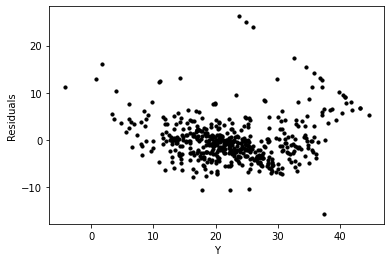

Значення,Параметр
A,1.520713
E,5.281482
ABS uA,14.048154
ABS uE,2.179176
Quantile,1.959964
skewtest statistic,10.581385
skewtest pvalue,0.000000
kurtosistest statistic,8.128678
kurtosistest pvalue,8.128678
normaltest statistic,178.041119


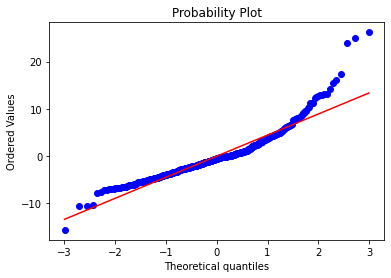

In [24]:
my_residuals_analysis(reg, residuals)